In [92]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 2, 1: 4, 2: 0, 3: 3, 4: 1}

Text(0.5, 1.0, 'edged image')

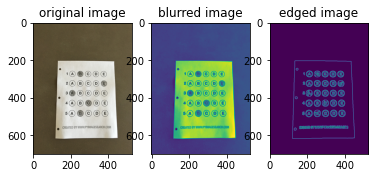

In [93]:
# load the image
img = cv2.imread('omr.png')
corr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1,3,1)
plt.imshow(corr_img)
plt.title('original image')
# convert it to grayscale and then blur it slightly then detect edges
gray = cv2.cvtColor(corr_img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0 )
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title('blurred image')
edged = cv2.Canny(blurred, 75, 200)
plt.subplot(1,3,3)
plt.imshow(edged)
plt.title('edged image')


In [94]:
# find contours in the edge map, then initialize the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None
# sort the contours in descending order 
if len(cnts)>0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # approximate the contours
    for i in cnts:
        peri = cv2.arcLength(i, True)
        epsilon = 0.02*peri
        approx = cv2.approxPolyDP(i, epsilon, True)
        # if approximated contour has 4 vertices then we can assume that we have found the paper
        if len(approx)==4:
            docCnt = approx
            break
            
    
    

In [95]:
# top down birds eye view of paper
paper = four_point_transform(img, docCnt.reshape(4,2))
warped = four_point_transform(gray, docCnt.reshape(4,2))

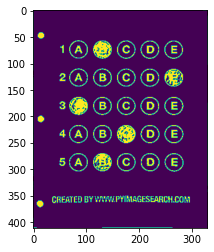

In [96]:
# apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped,0,255,
                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [97]:
# find contours in the thresholded image, then initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
# compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
for i in cnts:
    (x, y, w, h) = cv2.boundingRect(i)
    ar = w / float(h)
    # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and 
    #have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(i)

In [98]:
# sort the ques fron top to bottom & initialize no of correct ans
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
corr_que = 0
# each question has 5 possible answers, to loop over the question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from left to right, then initialize the index of the bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        # apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        # if the current total has a larger number of total non-zero pixels, then we are examining the currently bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
            print(bubbled)
        # initialize the contour color and the index of the *correct* answer
        color = (0, 0, 255)
        k = ANSWER_KEY[q]
        # check to see if the bubbled answer is correct
        if k == bubbled[1]:
            color = (0, 255, 0)
            corr_que += 1
            break
        # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3);
print(corr_que)

(289, 0)
(817, 1)
(279, 0)
(328, 1)
(686, 4)
(794, 0)
(294, 0)
(323, 1)
(805, 2)
(286, 0)
(722, 1)
3


In [99]:
# grab the test taker
score = (corr_que / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.imshow("Original", img)
cv2.imshow("Exam", paper)
cv2.waitKey(0)

[INFO] score: 60.00%


-1